In [70]:
import torch.backends.mps

from decoder import AttnDecoderRNN
from encoder import EncoderRNN
from evaluate import evaluate_losses, inference, evaluate_bleu, evaluate_loss
from dataloader import Lang
from io import open
import os
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu" if torch.backends.mps.is_available() else "cpu")
print(f'using device: {device}')

using device: cpu


In [71]:
initial_validation_size = 20000
max_length = 20
input_lang = Lang("en")
output_lang = Lang("de")

validation_english = open("data/train.en", encoding='utf-8').readlines()[:initial_validation_size]
validation_german = open("data/train.de", encoding='utf-8').readlines()[:initial_validation_size]
zipped = list(zip(validation_english, validation_german))
validation_english = [english for english, german in zipped
                      if len(input_lang.tokenize_without_truncation(english)) < max_length
                      and len(output_lang.tokenize_without_truncation(german)) < max_length]
validation_german = [german for english, german in zipped
                     if len(input_lang.tokenize_without_truncation(english)) < max_length
                     and len(output_lang.tokenize_without_truncation(german)) < max_length]
# validation_german = [[output_lang.decode(token) for token in output_lang.tokenize(sentence)][1:-1] for sentence in validation_german]
print(f"validation size: {len(validation_english)}")

validation size: 2534


In [ ]:
losses_list = []

In [72]:
model_names = [
"1e-3_lr_256_hidden_4_layers_20p_dropout",
"1e-4_lr_320_hidden_4_layers_10p_dropout",
"3e-4_lr_320_hidden_4_layers_20p_dropout",
"3e-5_lr_320_hidden_5_layers_30p_dropout",
"50p_tfr_1e-4_lr_320_hidden_4_layers_10p_dropout",
"80p_tfr_3e-4_lr_320_hidden_5_layers_30p_dropout",
"100p_tfr_1e-4_lr_320_hidden_6_layers_40p_dropout",
"100p_tfr_1e-4_lr_512_hidden_8_layers_50p_dropout",
"100p_tfr_2e-4_lr_400_hidden_8_layers_60p_dropout",
"100p_tfr_5e-5_lr_512_hidden_8_layers_60p_dropout_1e-4_weight_decay"]

In [73]:
lstm_model_names = [
"50p_tfr_1e-4_lr_320_hidden_4_layers_10p_dropout",
"80p_tfr_3e-4_lr_320_hidden_5_layers_30p_dropout",
"100p_tfr_1e-4_lr_320_hidden_6_layers_40p_dropout",
"100p_tfr_1e-4_lr_512_hidden_8_layers_50p_dropout",
"100p_tfr_2e-4_lr_400_hidden_8_layers_60p_dropout",
"100p_tfr_5e-5_lr_512_hidden_8_layers_60p_dropout_1e-4_weight_decay"
]

In [79]:
# losses_list = []
for i in range(6, 10):
    models_dir = "models_gru"
    model_name = model_names[i]
    plots_dir = "plots"

    encoder = torch.load(os.path.join(models_dir, model_name, "encoder.pt"), map_location=device)
    attn_decoder = torch.load(os.path.join(models_dir, model_name, "decoder.pt"), map_location=device)
    # prev_loss_history = np.load(os.path.join(plots_dir, model_name + "_full_history.npy")).tolist()
    # prev_plot_history = np.load(os.path.join(plots_dir, model_name + "_plot_history.npy")).tolist()

    print(f"Evaluating model {model_name}")
    loss, losses = evaluate_losses(encoder, attn_decoder, validation_english, validation_german, input_lang, output_lang, max_length, device)
    losses_list.append((loss, losses))
    print(f"Loss: {loss}")

Evaluating model 100p_tfr_1e-4_lr_320_hidden_6_layers_40p_dropout


100%|██████████| 2534/2534 [01:36<00:00, 26.15it/s]


Loss: 6.4230409764641365
Evaluating model 100p_tfr_1e-4_lr_512_hidden_8_layers_50p_dropout


100%|██████████| 2534/2534 [04:43<00:00,  8.95it/s]


Loss: 6.5789792041846304
Evaluating model 100p_tfr_2e-4_lr_400_hidden_8_layers_60p_dropout


100%|██████████| 2534/2534 [02:37<00:00, 16.09it/s]


Loss: 5.343697089046216
Evaluating model 100p_tfr_5e-5_lr_512_hidden_8_layers_60p_dropout_1e-4_weight_decay


100%|██████████| 2534/2534 [04:35<00:00,  9.19it/s]

Loss: 6.182204721664573


In [80]:
len(losses_list)

10

In [81]:
chencherry = SmoothingFunction()
all_bleu_scores = []

for i in range(10):
    models_dir = "models_gru"
    model_name = model_names[i]
    plots_dir = "plots"

    encoder = torch.load(os.path.join(models_dir, model_name, "encoder.pt"), map_location=device)
    decoder = torch.load(os.path.join(models_dir, model_name, "decoder.pt"), map_location=device)
    # prev_loss_history = np.load(os.path.join(plots_dir, model_name + "_full_history.npy")).tolist()
    # prev_plot_history = np.load(os.path.join(plots_dir, model_name + "_plot_history.npy")).tolist()

    print(f"Evaluating model {model_name}")
    bleu_scores = []
    for j in tqdm(range(len(validation_english))):
        prediction, _ = inference(encoder, decoder, validation_english[j], input_lang, output_lang, max_length, device)
        bleu_score = sentence_bleu(validation_german[j], prediction[1:-1], (0.25, 0.25, 0.25, 0.25), smoothing_function=chencherry.method1)
        bleu_scores.append(bleu_score)
    # print(f"Prediction: {prediction[1:-1]}")
    print(f"BLEU score: {np.mean(bleu_scores)}")
    all_bleu_scores.append(bleu_scores)
    # loss, losses = evaluate_losses(encoder, attn_decoder, validation_english, validation_german, input_lang, output_lang, max_length, device)
    # losses_list.append((loss, losses))
    # print(f"Loss: {loss}")

Evaluating model 1e-3_lr_256_hidden_4_layers_20p_dropout


100%|██████████| 2534/2534 [00:43<00:00, 58.81it/s]


BLEU score: 0.01851052731509908
Evaluating model 1e-4_lr_320_hidden_4_layers_10p_dropout


100%|██████████| 2534/2534 [01:04<00:00, 39.04it/s]


BLEU score: 0.019850148784967513
Evaluating model 3e-4_lr_320_hidden_4_layers_20p_dropout


100%|██████████| 2534/2534 [01:01<00:00, 41.19it/s]


BLEU score: 0.020956769419437464
Evaluating model 3e-5_lr_320_hidden_5_layers_30p_dropout


100%|██████████| 2534/2534 [01:12<00:00, 34.99it/s]


BLEU score: 0.019593766868267953
Evaluating model 50p_tfr_1e-4_lr_320_hidden_4_layers_10p_dropout


100%|██████████| 2534/2534 [01:10<00:00, 36.08it/s]


BLEU score: 0.016145903131326866
Evaluating model 80p_tfr_3e-4_lr_320_hidden_5_layers_30p_dropout


100%|██████████| 2534/2534 [01:16<00:00, 33.10it/s]


BLEU score: 0.018496671671504348
Evaluating model 100p_tfr_1e-4_lr_320_hidden_6_layers_40p_dropout


100%|██████████| 2534/2534 [01:21<00:00, 31.25it/s]


BLEU score: 0.01727141774437888
Evaluating model 100p_tfr_1e-4_lr_512_hidden_8_layers_50p_dropout


100%|██████████| 2534/2534 [04:19<00:00,  9.76it/s]


BLEU score: 0.01916688759200957
Evaluating model 100p_tfr_2e-4_lr_400_hidden_8_layers_60p_dropout


100%|██████████| 2534/2534 [02:17<00:00, 18.42it/s]


BLEU score: 0.025187662915206677
Evaluating model 100p_tfr_5e-5_lr_512_hidden_8_layers_60p_dropout_1e-4_weight_decay


100%|██████████| 2534/2534 [04:25<00:00,  9.53it/s]

BLEU score: 0.01747466013350437


In [102]:
models_of_interest = [4, 5, 8, 9]

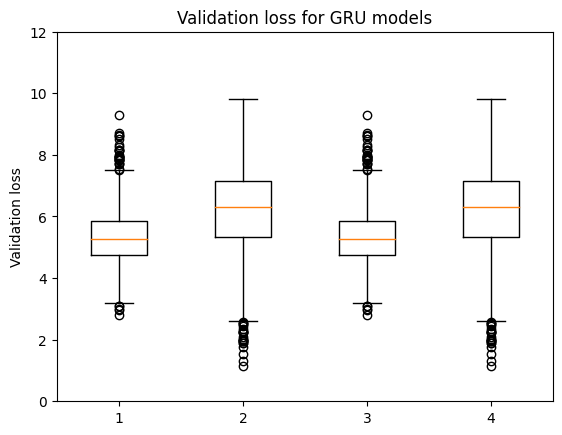

In [103]:
plt.boxplot([losses_list[i][1] for i in models_of_interest])
plt.ylabel("Validation loss")
plt.title("Validation loss for GRU models")
plt.ylim(0, 12)
plt.savefig("plots/losses_boxplot.png", bbox_inches='tight', dpi=300)

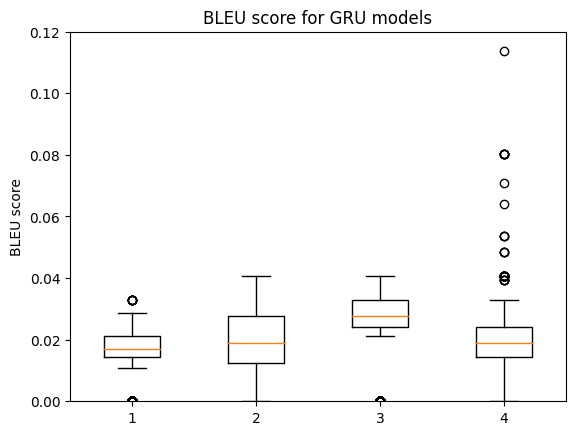

In [104]:
plt.boxplot([all_bleu_scores[i] for i in models_of_interest])
plt.ylabel("BLEU score")
plt.title("BLEU score for GRU models")
# set axis limits
plt.ylim(0.0, 0.12)
plt.savefig("plots/bleu_boxplot.png", bbox_inches='tight', dpi=300)